In [2]:
import os 
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [3]:
from keras.applications import VGG16
#Load the VGG model
image_size=32
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002611082FD68> False
<keras.layers.convolutional.Conv2D object at 0x0000026110A50048> False
<keras.layers.convolutional.Conv2D object at 0x0000026110DBA3C8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000026110DEEE10> False
<keras.layers.convolutional.Conv2D object at 0x0000026110DEE860> False
<keras.layers.convolutional.Conv2D object at 0x0000026110D7E898> False
<keras.layers.pooling.MaxPooling2D object at 0x0000026110E1BCF8> False
<keras.layers.convolutional.Conv2D object at 0x0000026110E1BA58> False
<keras.layers.convolutional.Conv2D object at 0x0000026110E80908> False
<keras.layers.convolutional.Conv2D object at 0x0000026110E94B70> False
<keras.layers.pooling.MaxPooling2D object at 0x0000026110EC9BE0> False
<keras.layers.convolutional.Conv2D object at 0x0000026110EC9DD8> False
<keras.layers.convolutional.Conv2D object at 0x0000026110EE5B00> False
<keras.layers.convolutional.Conv2D object at 0x0000026110EFD550> False
<ker

In [5]:
# Create the model
model = models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 15,243,075
Trainable params: 7,607,811
Non-trainable params: 7,635,264
_________________________________________________________________


In [6]:
train_dir='/Users/Mohit/Desktop/Iris_Imgs/train'
validation_dir='/Users/Mohit/Desktop/Iris_Imgs/test'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255) 
# Change the batchsize according to your system RAM
train_batchsize = 8
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        class_mode='categorical',
        shuffle=True)
test_imgs, test_labels = next(validation_generator)

Found 135 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [7]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
# Save the model
model.save('vgg_last4.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
17/16 [==============================] - 9s 546ms/step - loss: 0.7655 - acc: 0.6312 - val_loss: 0.4978 - val_acc: 0.8000
Epoch 2/20
17/16 [==============================] - 8s 444ms/step - loss: 0.4982 - acc: 0.8068 - val_loss: 0.4410 - val_acc: 0.8000
Epoch 3/20
17/16 [==============================] - 7s 439ms/step - loss: 0.4809 - acc: 0.8014 - val_loss: 0.3137 - val_acc: 0.8667
Epoch 4/20
17/16 [==============================] - 7s 436ms/step - loss: 0.3327 - acc: 0.8897 - val_loss: 0.4084 - val_acc: 0.8000
Epoch 5/20
17/16 [==============================] - 7s 434ms/step - loss: 0.3186 - acc: 0.8950 - val_loss: 0.3558 - val_acc: 0.8667
Epoch 6/20
17/16 [==============================] - 7s 436ms/step - loss: 0.2964 - acc: 0.8960 - val_loss: 0.4146 - val_acc: 0.8000
Epoch 7/20
17/16 [==============================] - 7s 432ms/step - loss: 0.2895 - acc: 0.8813 - val_loss: 0.2281 - val_acc: 0.9333
Epoch 8/20
17/16 [==========

In [8]:
score = model.evaluate(test_imgs,test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32697930932044983
Test accuracy: 0.8666666746139526


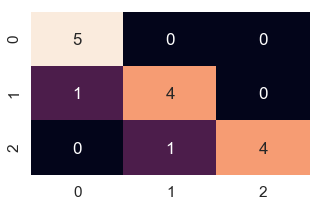

In [9]:
# calculate predictions
y_pred = model.predict(test_imgs,verbose=0, steps=None)
# Creating the Confusion Matrix
from numpy import argmax
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, cohen_kappa_score
cm = confusion_matrix(test_labels.argmax(axis=1), y_pred.argmax(axis=1) )
# Visualizing of confusion matrix
import seaborn as sn
df_cm = pd.DataFrame(cm, range(3),range(3))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,cbar=False)# font size
plt.show()

In [10]:
#What is the precision, and recall and f-score for each class prediction?
from sklearn import metrics
print(metrics.classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.80      0.80      0.80         5
           2       1.00      0.80      0.89         5

   micro avg       0.87      0.87      0.87        15
   macro avg       0.88      0.87      0.87        15
weighted avg       0.88      0.87      0.87        15



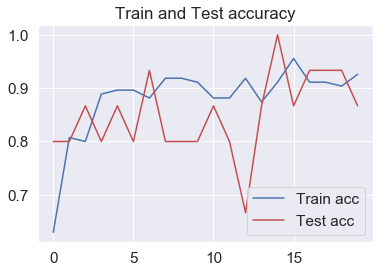

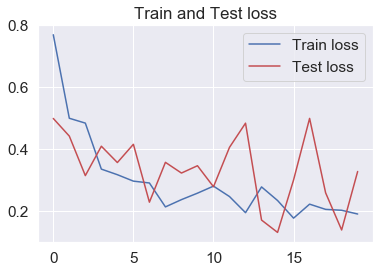

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Test acc')
plt.title('Train and Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Train and Test loss')
plt.legend()
plt.show()

In [13]:
#ROC Curve for each class
y_pred2 = model.predict_proba(test_imgs)[:,0] # for calculating the probability of the first class
y_pred3 = model.predict_proba(test_imgs)[:,1] # for calculating the probability of the second class
y_pred4 = model.predict_proba(test_imgs)[:,2] # for calculating the probability of the second class

auc for the first(0) class 1.0
auc for the second(1) class 0.94
auc for the third(2) class 1.0


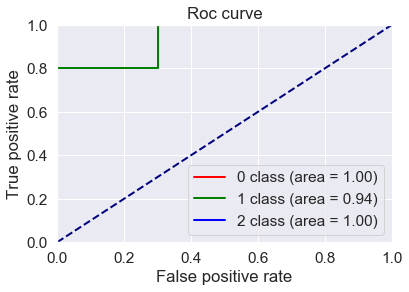

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels[:,0], y_pred2)
auc=metrics.auc(fpr, tpr)
print("auc for the first(0) class",auc)

fpr2, tpr2, thresholds2 = metrics.roc_curve(test_labels[:,1], y_pred3)
auc2=metrics.auc(fpr2, tpr2)
print("auc for the second(1) class",auc2)

fpr3, tpr3, thresholds3 = metrics.roc_curve(test_labels[:,2], y_pred4)
auc3=metrics.auc(fpr3, tpr3)
print("auc for the third(2) class",auc3)

# ploting the roc curve
plt.plot(fpr,tpr,color='red')
plt.plot(fpr2,tpr2,color='green')
plt.plot(fpr3,tpr3,color='blue')
plt.plot(fpr, tpr, color='red',lw=2, label='0 class (area = %0.2f)' % auc)
plt.plot(fpr2, tpr2, color='green',lw=2, label='1 class (area = %0.2f)' % auc2)
plt.plot(fpr3, tpr3, color='blue',lw=2, label='2 class (area = %0.2f)' % auc3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('Roc curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()